**Table of contents**<a id='toc0_'></a>    
- [Purpose of the notebook](#toc1_)    
- [Statistics of block completeness after only percentage based trial rejection](#toc2_)    
    - [Number of blocks remaining per participant](#toc2_1_1_)    
    - [Timeline of blocks availability](#toc2_1_2_)    
- [Block completeness after percentage and long nan trial removal](#toc3_)    
    - [Number of blocks remaining per participant](#toc3_1_1_)    
    - [Timeline of blocks availability](#toc3_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Purpose of the notebook](#toc0_)

This notebook deals with computing, visualizing and saving to csv the conditions available in blocks after removal of bad trials (e.g. based on data completeness, based on long gaps).

In [1]:
import sys

sys.path.insert(
    1, "..\\utilities\\"
)  # adds utilities folder to path so we can import modules from it, won't be needed after packaging

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import loading_utils as load
import preprocessing_utils as prep

participant_list = [200, 201, 202, 204, 205, 206, 207, 209, 210, 211, 212, 213]

In [2]:
data_dir = "./results/resampled/"  # directory with resampled data
data_suffix = "_nonan_30_resampled_data.csv"  # name of file with 30 Hz resampled data from participant 2xx, name format: 2xxdata_suffix

In [3]:
# This is a block for making participant dataframes from raw files in directory data_dir (here Windows path to retinawise mirror folder on drive)
# It saves the participant dfs into directory defined in save_path (about 300 - 400 MB per participant), format 2xx_recording_data.csv
# Uncomment and run if you don't have these dataframes (remember that the folder specified in save_path must exist)
# data_dir = "D:/retinawise_mirror/raw/"
# save_path = './results/'
# for participant_id in participant_list:
#     data_df, protocol_timecourse_df, protocol_vars_df = load.load_participant_data(participant_no=participant_id,
#                                                                                    data_dir=data_dir,
#                                                                                    include_failed=False,
#                                                                                    save=True,
#                                                                                    save_path=save_path)

In [4]:
# This is a block for resampling participant dataframes to 30 Hz and extracting only trials -1:18 s
# It loads the participant dfs from data_dir (e.g. the save_path from block above)
# And saves into directory save_path with format 2xxdata_suffix
# Uncomment and run if you don't have the resampled dataframes (remember the folder specified in save_path must exist)
# data_dir = "./results/"
# save_path = './results/resampled/'
# data_suffix = "_nonan_30_resampled_data.csv"
# for participant_id in participant_list:
#     data_path = os.path.join(data_dir,str(participant_id)+'_recording_data.csv')
#     data_df = pd.read_csv(data_path)
#     resampled_df = prep.resample_by_trial(data_df,sample_freq=30)
#     save_filepath = os.path.join(save_path,str(participant_id)+data_suffix)
#     resampled_df.to_csv(save_filepath)
#     data_df = []
#     resampled_df = []

In [5]:
def rejection_pipeline(data_df,funcs):
    new_df = data_df.copy(deep=True)
    for func in funcs:
        new_df = func(new_df)
    return new_df

# <a id='toc2_'></a>[Statistics of block completeness after only percentage based trial rejection](#toc0_)

complete trial: 75% POI 1:6 s, 40% baseline -1:0 s

complete condition in a block: min. 3 accepted trials

complete block: has complete flux and complete other condition, 'block available for condition' is if that condition+flux are present

In [6]:
funcs = [prep.remove_trials_below_percentage,prep.remove_bad_conditions,prep.remove_bad_blocks]

In [7]:
blocks = np.arange(0,11)
conditions = ['flux','l-m','lms','mel','s']

def make_completeness_stats_df(participant_list,blocks,conditions,funcs):
    completeness_dict = {'Participant':[],'Block':[],'Condition':[],'Trial count':[],'Block available':[]}

    for participant_id in participant_list:
        data_path = os.path.join(data_dir, str(participant_id) + data_suffix)
        data_df = pd.read_csv(data_path)

        no_low_block_df = rejection_pipeline(data_df,funcs)
        
        groupby_df = (
        no_low_block_df[["Block", "Trial type", "Trial no"]]
        .groupby(["Block", "Trial type"])
        .agg("nunique")
    )
        
        groupby_df.reset_index(inplace=True)
        
        
        for block in blocks:
            for condition in conditions:
                if block in groupby_df['Block'].values:
                    
                    if condition in groupby_df['Trial type'][groupby_df['Block']==block].values:
                        count = groupby_df['Trial no'][(groupby_df['Block']==block)&(groupby_df['Trial type']==condition)].values[0]
                        block_acc = 'yes'
                    else:
                        count = 'less than 3'
                        block_acc = 'no'
                else:
                    block_acc = 'no'
                    count = 'less than 3'
                completeness_dict['Participant'].append(participant_id)
                completeness_dict['Block'].append(block)
                completeness_dict['Condition'].append(condition)
                completeness_dict['Trial count'].append(count)
                completeness_dict['Block available'].append(block_acc)

    completeness_df = pd.DataFrame(completeness_dict)
    return completeness_df

In [8]:
percentage_removal_compl_df = make_completeness_stats_df(participant_list,blocks,conditions,funcs)

In [9]:
percentage_removal_compl_df.to_csv('block_completeness_percentage_only.csv')

### <a id='toc2_1_1_'></a>[Number of blocks remaining per participant](#toc0_)

In [10]:
percentage_removal_compl_df[['Participant','Block']][percentage_removal_compl_df['Block available'] == 'yes'].groupby(['Participant']).nunique()

,Block
Participant,
200,11
201,11
202,11
204,11
205,7
206,10
207,8
209,4
210,6


Groupby above shows how many blocks are left for each participant without differentiating by condition.

### <a id='toc2_1_2_'></a>[Timeline of blocks availability](#toc0_)

In the plot, if condition in block is available, there is a marker. If not, there is a gap.

In [11]:
def plot_block_timeline_per_condition(completeness_df):
    fig,axes = plt.subplots(2,6,figsize=(15,5),sharex=True,sharey=True)
    for participant_id,ax in zip(sorted(completeness_df['Participant'].unique()),axes.flat):
        subset_df = completeness_df[completeness_df['Participant']==participant_id]
        subset_df.reset_index(inplace=True)
        subset_df.loc[subset_df['Trial count']=='less than 3','Trial count']=pd.NA
        for i,cond in enumerate(sorted(subset_df['Condition'].unique())):
            subset_df.loc[(subset_df['Condition']==cond)&(subset_df['Trial count'].notna()),'Trial count'] = i
        
        sns.pointplot(ax = ax,data=subset_df,x='Block',y='Trial count',hue='Condition',linewidth=1.5,markersize=2.3)
        ax.set_title('Participant '+str(participant_id))
        ax.set_ylabel('Condition')
        ax.set_yticks([0,1,2,3,4],labels=['flux','l-m','lms','mel','s'])
        ax.legend([])
    plt.tight_layout()
    plt.show()
        

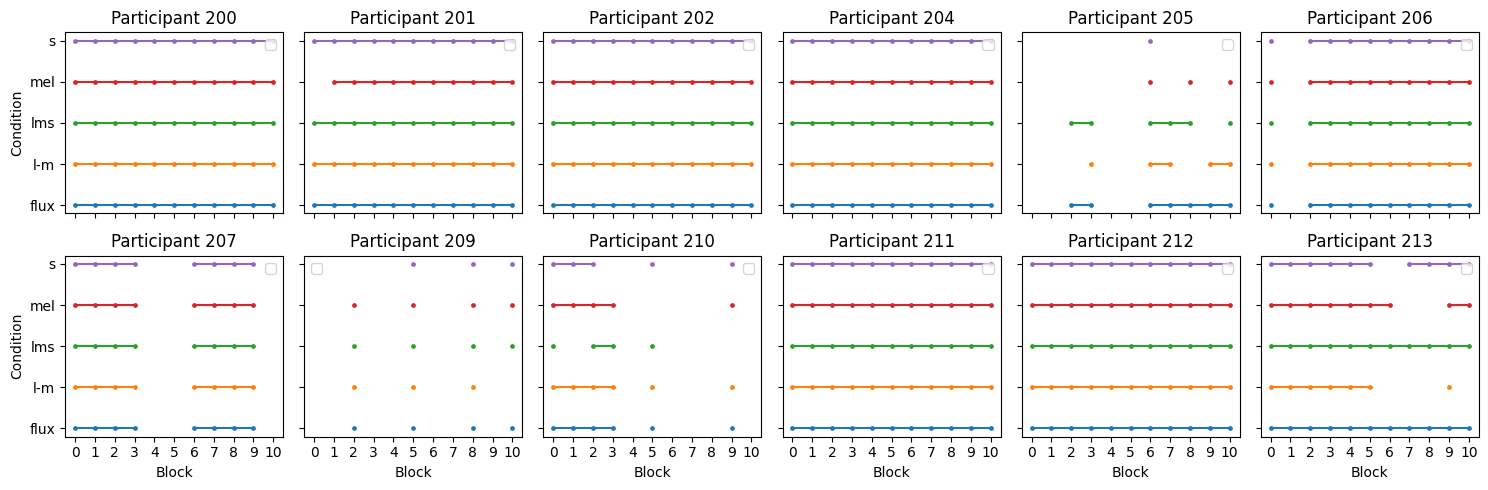

In [12]:
plot_block_timeline_per_condition(percentage_removal_compl_df)

After looking at the plots, there are 7 participants that stand out as having high block/condition completeness (as in, a lot of/almost all blocks available for conditions and no consecutive block gaps): 200, 201, 202, 204, 206, 210, 211, 212. Additionally, there are participants,where analysis can be performed on a subset of conditions, e.g. 213.

# <a id='toc3_'></a>[Block completeness after percentage and long nan trial removal](#toc0_)

Conditions as above plus removal of trials with NaNs longer than 625 ms.

In [13]:
funcs = [prep.remove_trials_below_percentage,prep.remove_trials_with_long_nans,prep.remove_bad_conditions,prep.remove_bad_blocks]

In [14]:
percentage_nan_removal_compl_df = make_completeness_stats_df(participant_list,blocks,conditions,funcs)
percentage_nan_removal_compl_df.to_csv('block_completeness_percentage_nans.csv')

### <a id='toc3_1_1_'></a>[Number of blocks remaining per participant](#toc0_)

In [15]:
percentage_nan_removal_compl_df[['Participant','Block']][percentage_nan_removal_compl_df['Block available'] == 'yes'].groupby(['Participant']).nunique()

,Block
Participant,
200,11
201,11
202,11
204,11
205,6
206,10
207,8
209,4
210,4


### <a id='toc3_1_2_'></a>[Timeline of blocks availability](#toc0_)

as above, marker==block available for condition.

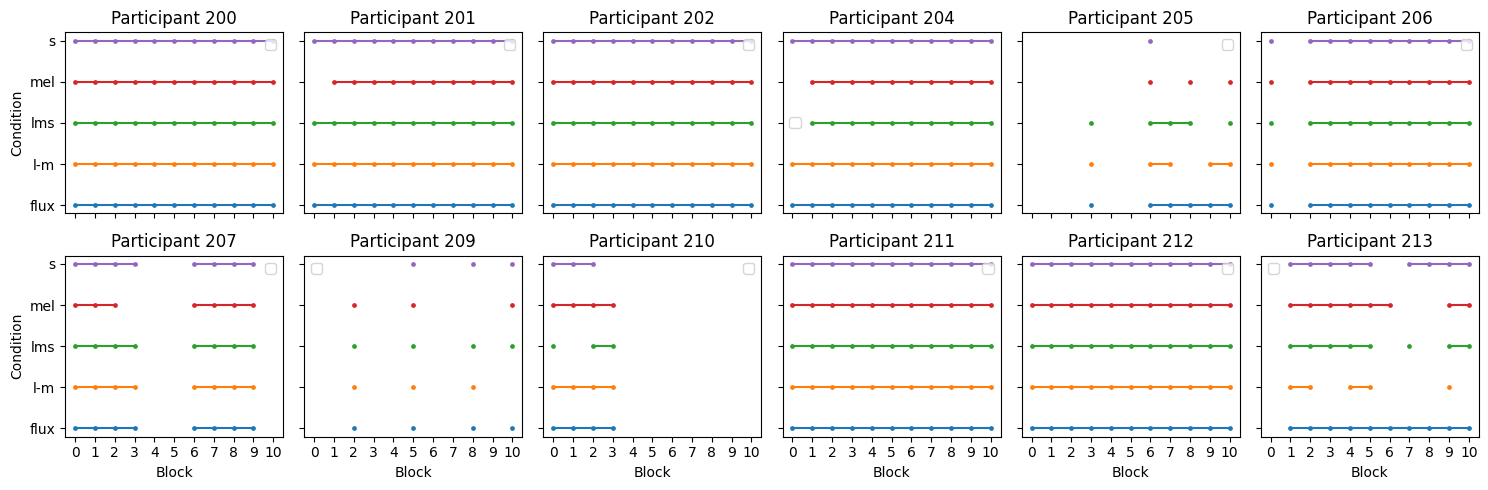

In [16]:
plot_block_timeline_per_condition(percentage_nan_removal_compl_df)

For completeness statistics after percentage and NaN duration based rejection, we can see that it doesn't change a lot for participants defined as 'good', as in: 200, 201, 202, 206, 211, 212, with the exception of 204, where the availability got visibly lower. Still, even for 204, the gaps are still not long so there can be potential for evaluation. Same goes for 213, where e.g. conditions s and lms only have 1 block long gaps.

# Block completeness after artefact cleaning, percentage-based removal, long NaN based removal

Artefact removal consists of: 

-removal of non-physiological pupil size values (outside of 1.5-9 mm range)

-removal of artefacts in pupil velocity based on MAD threshold with multiplier 4.5 (about 3 standard deviations)

-removal of artefacts in pupil size based on rolling MAD threshold with window of 2 seconds and multiplier 4.5


In [17]:
funcs = [prep.remove_artifacts_phase_velocity_mad,prep.remove_artifacts_rolling_size_mad,
         prep.remove_trials_below_percentage,prep.remove_trials_with_long_nans,prep.remove_bad_conditions,prep.remove_bad_blocks]

In [18]:
art_percentage_nan_removal_compl_df = make_completeness_stats_df(participant_list,blocks,conditions,funcs)
art_percentage_nan_removal_compl_df.to_csv('block_completeness_artefacts_percentage_nans.csv')

c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy

In [19]:
art_percentage_nan_removal_compl_df[['Participant','Block']][art_percentage_nan_removal_compl_df['Block available'] == 'yes'].groupby(['Participant']).nunique()

,Block
Participant,
200,11
201,11
202,11
204,7
205,4
206,10
207,6
209,1
210,2


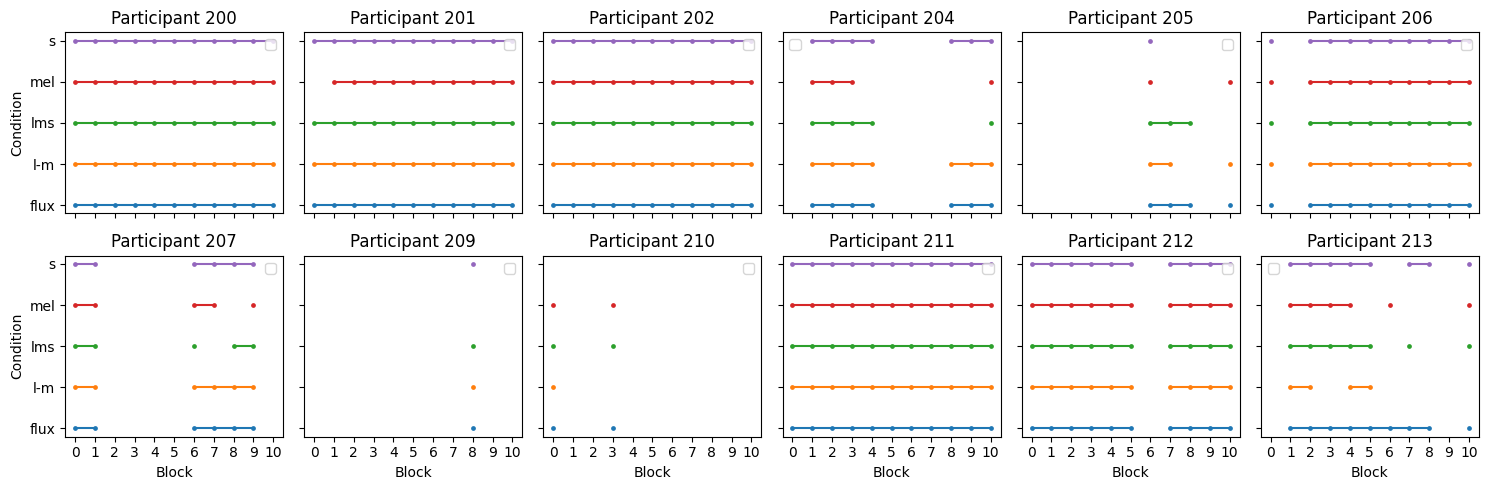

In [20]:
plot_block_timeline_per_condition(art_percentage_nan_removal_compl_df)

In particular, participant 204's available data appears to be greatly reduced after artifact removal. Participants 200, 201, 202, 206, 211, 212 have almost unchanged block/condition availability. For participant 213, only condition s seems to be suitable, as it has no gaps longer than 1 block. Possibly lms could be usable as well.